# Diving deep into the Panama Papers

## **What are the key figures about the evolution of Mossack Fonseca's clients at different scales over the span of 40 years ? How can we put these figures into historical (economy, laws, policies...) context ?**

In [1]:
#Imports
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import warnings
import networkx as nx
import collections
from operator import itemgetter
from functools import reduce
from IPython.display import Image

warnings.simplefilter('ignore')
PATH = './Data'

Some terms definition (cf https://offshoreleaks.icij.org/pages/faq#terms_definition):  
  
- Entity: A company, trust or fund created by an agent
- Officer: A person or company who plays a role in an offshore entity
- Intermediary: A go-between for someone seeking an offshore corporation and an offshore service provider
- Address: Contact postal address as it appears in the original databases obtained by ICIJ

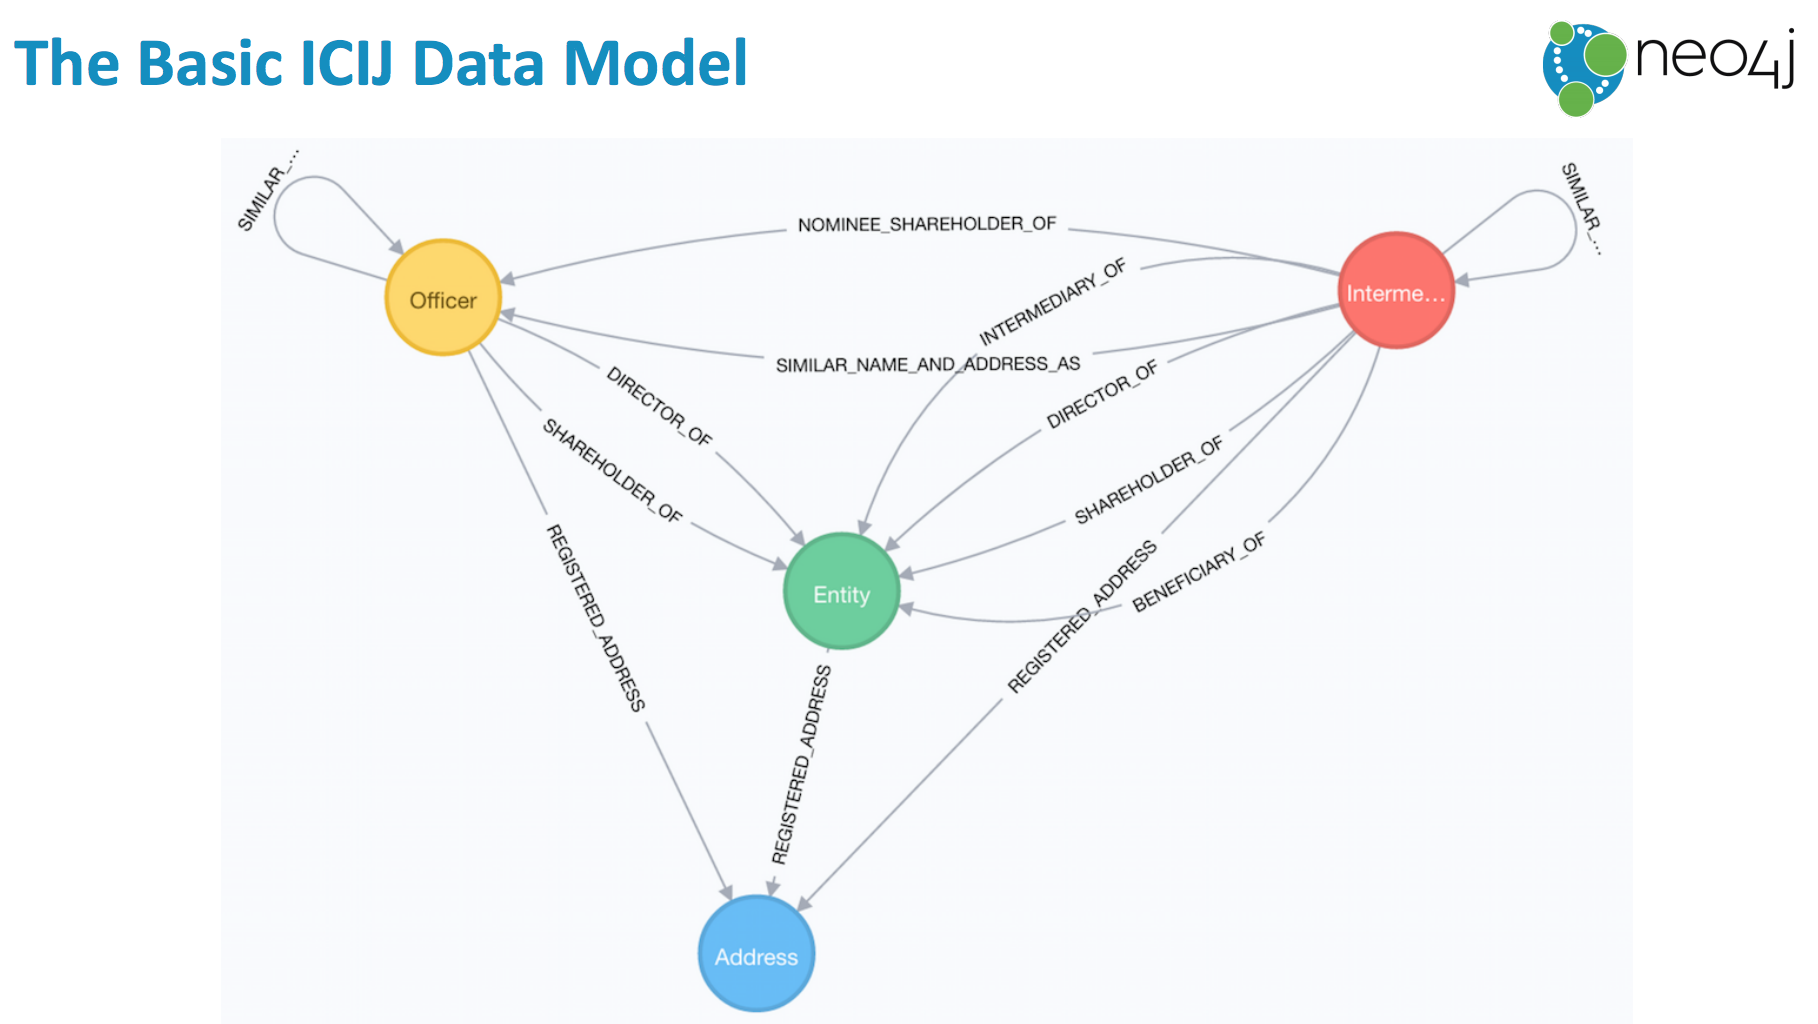

In [2]:
#The Panama Papers: Using open source tools for investigative journalism by Michael Hunger
Image(filename = PATH + "/Schema.png", width=700, height=700)

In [3]:
#Load each csv file into a dataframe
address = pd.read_csv(PATH+'/address.csv')
edges = pd.read_csv(PATH+'/edges.csv')
entity = pd.read_csv(PATH+'/entity.csv')
intermediary = pd.read_csv(PATH+'/intermediary.csv')
officer = pd.read_csv(PATH+'/officer.csv')

Inspection of the data reveals that some columns are either empty (note...) or contain redundant/useless information (valid_until, countries vs country_code...). Therefore we shall get rid of them.  
Moreover, we convert dates to the datetime format for further manipulations.  
We also observe that node ids in each dataframe are unique. In the edges dataframe the key is start_id, end_id, link.

Note that we may have to perform additional data transformation regarding names and addresses if need be.

In [4]:
#Drop useless columns
address.drop(['name', 'sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
edges.drop(['sourceID', 'valid_until'], axis=1, inplace=True)
officer.drop(['sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
intermediary.drop(['sourceID', 'valid_until', 'note', 'country_codes'], axis=1, inplace=True)
entity.drop(['closed_date', 'company_type', 'service_provider', 'sourceID', 'valid_until', 'note', 'country_codes', 'jurisdiction'], axis=1, inplace=True)

In [5]:
#Convert dates to datetime
entity['incorporation_date'] = pd.to_datetime(entity['incorporation_date'], format='%d-%b-%Y')
entity['inactivation_date'] = pd.to_datetime(entity['inactivation_date'], format='%d-%b-%Y')
entity['struck_off_date'] = pd.to_datetime(entity['struck_off_date'], format='%d-%b-%Y', errors='coerce')

Let's have a quick look at each dataframe

In [6]:
print('Address: {} entries'.format(address.shape[0]))
address.head()

Address: 93454 entries


,node_id,address,countries
0,14000001,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,Singapore
1,14000002,"""Almaly Village"" v.5, Almaty Kazakhstan",Kazakhstan
2,14000003,"""Cantonia"" South Road St Georges Hill Weybridg...",United Kingdom
3,14000004,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",Guernsey
4,14000005,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",Kenya


In [7]:
print('Edges:',edges.shape[0],'entries')
edges.head()

Edges: 674102 entries


,START_ID,TYPE,END_ID,link,start_date,end_date
0,10000035,registered_address,14095990,registered address,NaN,NaN
1,10000044,registered_address,14091035,registered address,NaN,NaN
2,10000055,registered_address,14095990,registered address,NaN,NaN
3,10000064,registered_address,14091429,registered address,NaN,NaN
4,10000089,registered_address,14098253,registered address,NaN,NaN


In [8]:
print('Entity:',entity.shape[0],'entries')
entity.head()

Entity: 213634 entries


,node_id,name,jurisdiction_description,countries,incorporation_date,inactivation_date,struck_off_date,ibcRUC,status
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",Samoa,Hong Kong,2006-03-23,2013-02-18,2013-02-15,25221,Defaulted
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",Samoa,Hong Kong,2006-03-27,2014-02-27,2014-02-15,25249,Defaulted
2,10000003,"HOTFOCUS CO., LTD.",Samoa,Hong Kong,2006-01-10,2012-02-15,2012-02-15,24138,Defaulted
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.",Samoa,Hong Kong,2006-01-06,2009-02-16,2009-02-15,24012,Defaulted
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,Samoa,Hong Kong,2006-04-19,2009-05-15,2008-02-15,R25638,Changed agent


In [9]:
print('Intermediary:',intermediary.shape[0],'entries')
intermediary.head()

Intermediary: 14110 entries


,node_id,name,countries,status
0,11000001,"MICHAEL PAPAGEORGE, MR.",South Africa,ACTIVE
1,11000002,CORFIDUCIA ANSTALT,Liechtenstein,ACTIVE
2,11000003,"DAVID, RONALD",Monaco,SUSPENDED
3,11000004,"DE BOUTSELIS, JEAN-PIERRE",Belgium,SUSPENDED
4,11000005,THE LEVANT LAWYERS (TLL),Lebanon,ACTIVE


In [10]:
print('Officer',officer.shape[0],'entries')
officer.head()

Officer 238402 entries


,node_id,name,countries
0,12000001,KIM SOO IN,South Korea
1,12000002,Tian Yuan,China
2,12000003,GREGORY JOHN SOLOMON,Australia
3,12000004,MATSUDA MASUMI,Japan
4,12000005,HO THUY NGA,Viet Nam


**Let's obtain key figures about the Panama Papers**

In [11]:
#Plot value counts
def plot_counts(title, data):
    plt.figure(figsize=(8,4))
    data.plot(kind='bar')
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=85)
    plt.plot()

**We start with entities**

Top 10 Number of offshore entities per jurisdiction

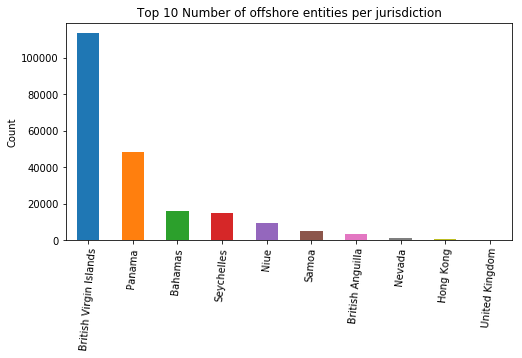

In [12]:
juris = entity['jurisdiction_description'].value_counts()
plot_counts("Top 10 Number of offshore entities per jurisdiction", juris[:10])

The most represented jurisdictions are tax heavens themselves. They act as intermediary countries for tax evasion. This is not good news since it will be much harder to extract relevant information about the largest countries involved.

Top 15 Number of offshore entities per country

One must make a distinction between country and jurisdiction:  
The difference between jurisdiction and country is that jurisdiction is the power, right, or authority to interpret and apply the law while country is (label) an area of land; a district, region. (cf https://wikidiff.com/jurisdiction/country)  


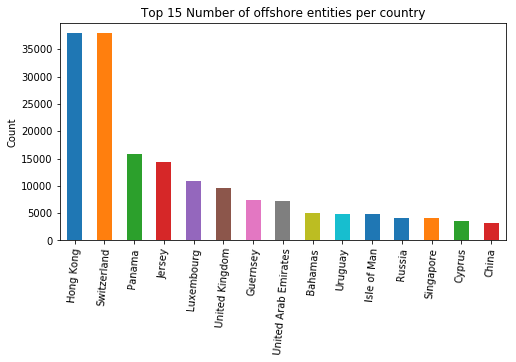

In [13]:
countries = entity['countries'].value_counts()
plot_counts("Top 15 Number of offshore entities per country", countries[:15])

Number of incorporated offshore companies per year

In [14]:
def plot_incorporated(data, title, lim=(1973,2017), ticks=range(1975, 2020, 5)):
    """"Plot the number of incorporated offshore companies per year for a specific period"""
    plt.figure(figsize=(10,5))
    data.loc[lim[0]:lim[1]].plot(kind='line')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(ticks)
    plt.plot()

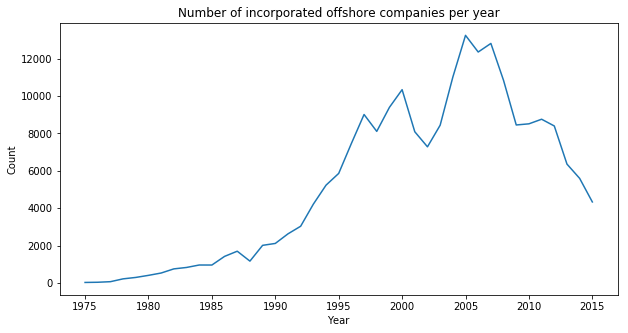

In [15]:
dates = entity['incorporation_date'].dt.year
incorp = dates[dates >= 1975].value_counts().sort_index()

plot_incorporated(incorp, 'Number of incorporated offshore companies per year')

Let's dig deeper into that graph: we locate interesting dips and peaks and try to link them to historical events.

-1970: For decades, offshore finance had a relatively modest profile in Panama. Nothing to report.

1975-2000: "But it took off in the 1970s as world oil prices surged. During this time, the Republic of Panama passed legislation entrenching corporate and individual financial secrecy." (Cf Wikipedia: Financial secrecy in Panama)


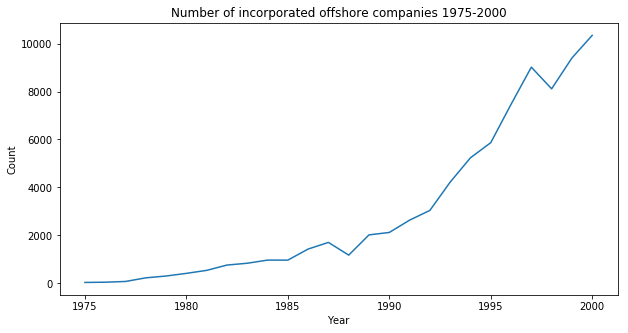

In [16]:
plot_incorporated(incorp, 'Number of incorporated offshore companies 1975-2000', (1975,2000))

1985-1990: Political crisis resulting in an invasion by the USA from 1989 to 1990.

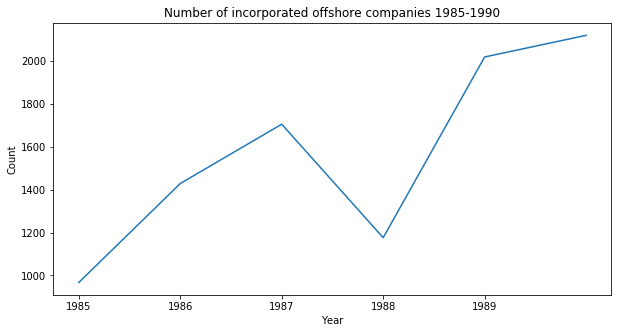

In [17]:
plot_incorporated(incorp, 'Number of incorporated offshore companies 1985-1990', (1985,1990), range(1985, 1990, 1))

2000-2005: "The 2000 OECD report, "Towards Global Tax Co-operation", included a list of 35 jurisdictions that were found to meet the tax haven criteria  set out in an earlier report issued in 1998." Guess who was listed ? Panama.

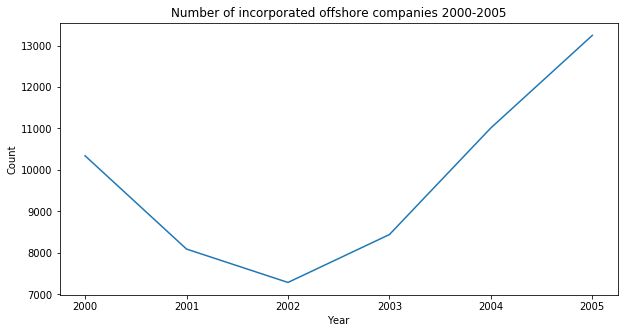

In [18]:
plot_incorporated(incorp, 'Number of incorporated offshore companies 2000-2005', (2000,2005), range(2000, 2006, 1))

2007-2015: The subprime crisis and the years after it. We notice a net decline in the number of incorporated offshore companies during that period. Ultimately the papers were leaked and that is where the records stop.

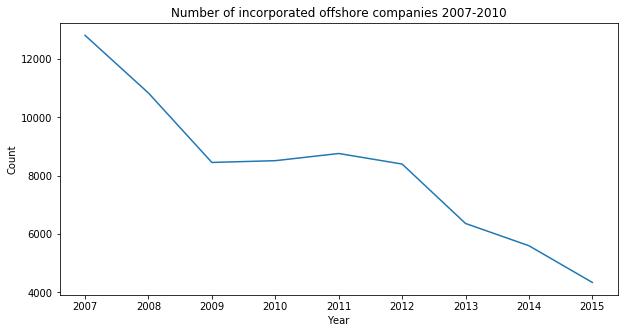

In [19]:
plot_incorporated(incorp, 'Number of incorporated offshore companies 2007-2010', (2007,2015), range(2007, 2016, 1))

Number of incorporated offshore companies per year per jurisdiction

[]

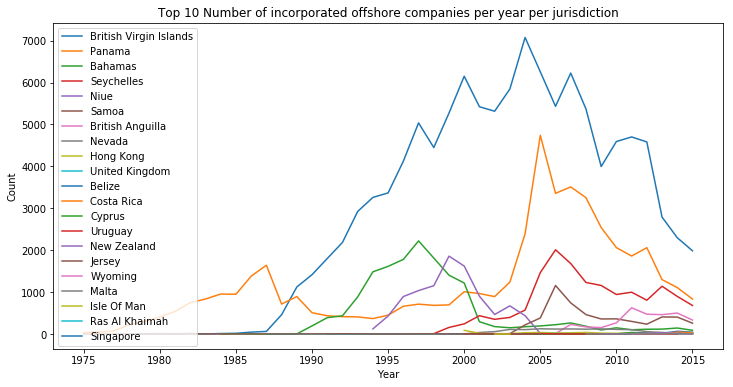

In [20]:
#Get data after 1975 and about the top 10 jurisdictions
juris_dates = pd.concat([entity['jurisdiction_description'], dates], axis=1)
juris_dates = juris_dates[(juris_dates['incorporation_date'] >= 1975) & (juris_dates['jurisdiction_description'].isin(juris.index))]
juris_dates = juris_dates.groupby(['jurisdiction_description','incorporation_date']).size().reset_index()
juris_dates.columns = ['jurisdiction_description', 'incorporation_date', 'count']

#Plot data
plt.figure(figsize=(12,6))
for j in juris.index:
    incor_juris = juris_dates[juris_dates['jurisdiction_description']==j]
    plt.plot(incor_juris['incorporation_date'], incor_juris['count'])  
plt.title('Top 10 Number of incorporated offshore companies per year per jurisdiction')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(juris.index)
plt.xticks(range(1975, 2020, 5))
plt.plot()

Number of incorporated offshore companies per year per country

[]

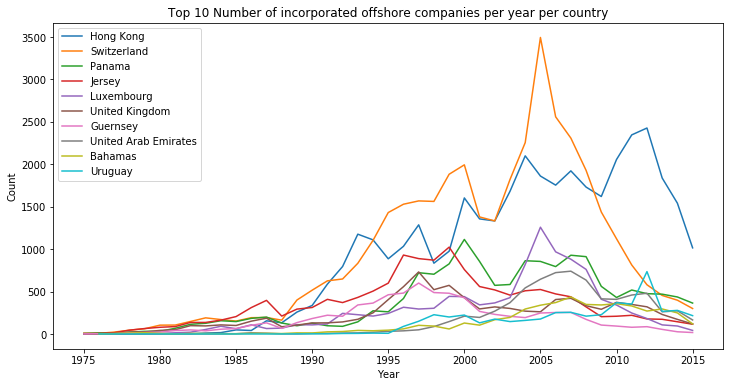

In [21]:
#Bis repetita of previous query
country_dates = pd.concat([entity['countries'], dates], axis=1)
country_dates = country_dates[(country_dates['incorporation_date'] >= 1975) & (country_dates['countries'].isin(countries.index[:10]))]
country_dates = country_dates.groupby(['countries','incorporation_date']).size().reset_index()
country_dates.columns = ['countries', 'incorporation_date', 'count']

#Plot data
plt.figure(figsize=(12,6))
for c in countries.index[:10]:
    incor_country = country_dates[country_dates['countries']==c]
    plt.plot(incor_country['incorporation_date'], incor_country['count'])  
plt.title('Top 10 Number of incorporated offshore companies per year per country')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(countries.index[:10])
plt.xticks(range(1975, 2020, 5))
plt.plot()

**We continue with intermediaries**

Top 15 Number of intermediaries per country

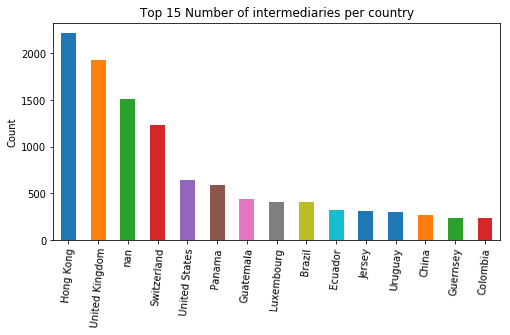

In [22]:
#First we need to explode the countries column since one intermediary may have multiple countries
inter_countries = intermediary['countries'].astype(str).apply(lambda s: s.split(';'))
inter_countries = inter_countries.apply(pd.Series).stack().reset_index(drop=True)
inter_countries = inter_countries.value_counts()

plot_counts("Top 15 Number of intermediaries per country", inter_countries[:15])

Note that we include intermediaries with no specified country (nan).  
It looks like that entities and intermediaries locations are correlated. That is countries host both entities and intermediaries. However we observe that some of the largest countries display a significant number of intermediaries (while they are lacking in number of entities). We shall put this hypothesis to the test when we tackle officers.

Distribution of intermediaries' status

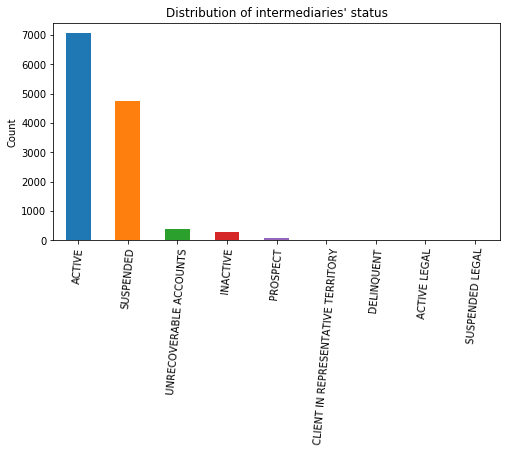

In [23]:
inter_status = intermediary['status'].value_counts()
plot_counts("Distribution of intermediaries' status", inter_status)

Intermediaries that requested the most offshore companies creations

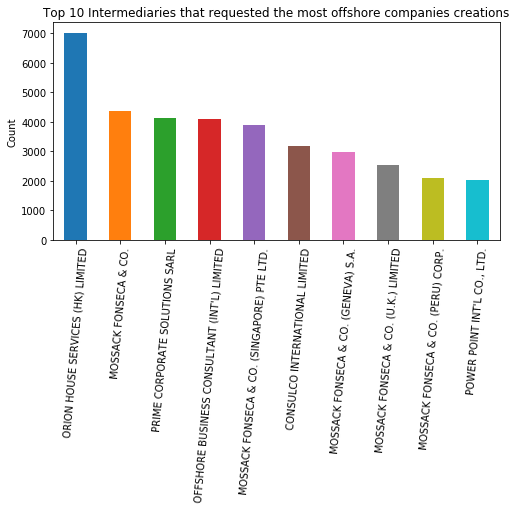

In [24]:
requests_ids = edges[edges.TYPE == 'intermediary_of'].START_ID.to_frame()
most_requests = requests_ids.merge(intermediary, left_on='START_ID', right_on='node_id')
counts_requests = most_requests['name'].value_counts()

plot_counts("Top 10 Intermediaries that requested the most offshore companies creations", counts_requests[:10])

In the next milestone we will dig a bit deeper into the swiss intermediaries involved. We will see that they rank quite high in the hierarchy.

**We investigate the possible relationships between "nodes"**

Top 5 Number of links between nodes

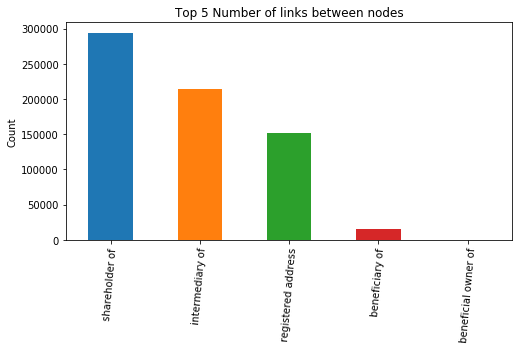

In [25]:
links = edges['link'].value_counts()

plot_counts("Top 5 Number of links between nodes", links[:5])

**Officers here we come**

Top 15 Number of officers per country

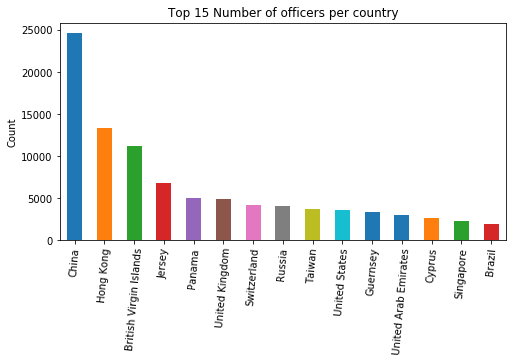

In [26]:
off_countries = officer['countries'].value_counts()

plot_counts("Top 15 Number of officers per country", off_countries[:15])

Let's put the hypothesis that the number of entities/intermediaries/officers per country are correlated to the test.  
Since we can't assume a normal distribution (the distribution of nodes degrees in general is most likely a pseudo power-law which we will observe) we will resort to the spearman rank-order correlation statistic.

In [27]:
entity_officer = pd.concat([countries, off_countries], axis=1).dropna(how='any')
entity_officer.columns = ['Entity', 'Officer']
corr_entity_officer = st.spearmanr(entity_officer.Entity, entity_officer.Officer)

In [28]:
entity_intermediary = pd.concat([countries, inter_countries], axis=1).dropna(how='any')
entity_intermediary.columns = ['Entity', 'Intermediary']
corr_entity_intermediary = st.spearmanr(entity_intermediary.Entity, entity_intermediary.Intermediary)

In [29]:
officer_intermediary = pd.concat([off_countries, inter_countries], axis=1).dropna(how='any')
officer_intermediary.columns = ['Officer', 'Intermediary']
corr_officer_intermediary = st.spearmanr(officer_intermediary.Officer, officer_intermediary.Intermediary)

In [30]:
print('Entity/Intermediary Correlation: {} p value: {}'.format(corr_entity_intermediary[0], corr_entity_intermediary[1]))
print('Entity/Officer Correlation: {} p value: {}'.format(corr_entity_officer[0], corr_entity_officer[1]))
print('Officer/Intermediary Correlation: {} p value: {}'.format(corr_officer_intermediary[0], corr_officer_intermediary[1]))

Entity/Intermediary Correlation: 0.8919548951483216 p value: 2.0214949834649082e-49
Entity/Officer Correlation: 0.8215170964621752 p value: 6.715541743931577e-40
Officer/Intermediary Correlation: 0.7921095416806456 p value: 2.2046713958838774e-31


[]

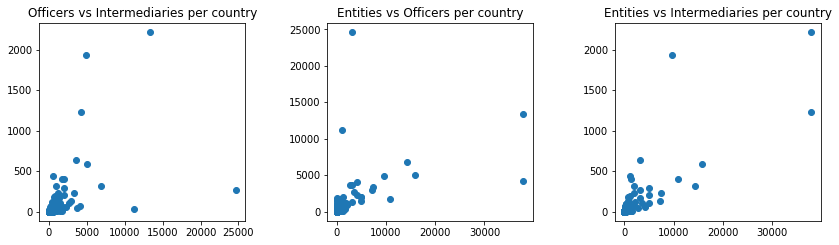

In [31]:
fig = plt.figure(figsize=(14,8))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)

ax1.scatter(officer_intermediary.Officer, officer_intermediary.Intermediary)
ax1.set_title("Officers vs Intermediaries per country")
ax2.scatter(entity_officer.Entity, entity_officer.Officer)
ax2.set_title("Entities vs Officers per country")
ax3.scatter(entity_intermediary.Entity, entity_intermediary.Intermediary)
ax3.set_title("Entities vs Intermediaries per country")
plt.plot()

A correlation coefficient close to one suggests a strong monotonic relationship which is our case. In all three cases infinitesimal p values allow us to reject the null hypothesis that there is no correlation at almost any significance level.  
  
However a visual inspection of the data indicates that we should be more careful about our claims. Indeed we observe some clear outliers and a cluster of points in the lower left part of the plot. We don't display all of the plots but basically we did the following:
- Set a line of threshold values
- Get rid of "outliers" past each threshold
- Compute the correlation statistic and visualize the data on the filtered (population controlled) observations
- Profit

For each threshold our results still suggest a strong monotonic relationship.

**Bearer shares gotta catch em all !**

Companies held by bearer shares often don’t need to register an owner’s name – ownership is determined by whoever holds the share certificates, providing a deep level of secrecy. When the British Virgin Islands cracked down on bearer shares in 2005, Mossack Fonseca moved bearer share clients to Panama. (cf https://www.icij.org/investigations/panama-papers/explore-panama-papers-key-figures/).

Number of bearer shareholders per jurisdiction

In [32]:
#Get bearers, shareholders and entities ids
bearers = officer[officer['name'].str.contains('bearer|el portador', case=False, na=False)]['node_id'].to_frame()
sholders = edges[edges['link'].str.contains('shareholder', case=False, na=False)][['START_ID', 'END_ID']]
id_juris_dates = pd.concat([entity['node_id'], entity['jurisdiction_description'], dates], axis=1)
id_juris_dates = id_juris_dates[id_juris_dates['incorporation_date'] >= 1985]

In [33]:
#Merge dataframes
join1 = bearers.merge(sholders, left_on='node_id', right_on='START_ID')
join2 = join1.merge(id_juris_dates, left_on='END_ID', right_on='node_id')
join2 = join2.groupby(['jurisdiction_description','incorporation_date']).size().reset_index()
join2.columns = ['jurisdiction_description', 'incorporation_date', 'count']

[]

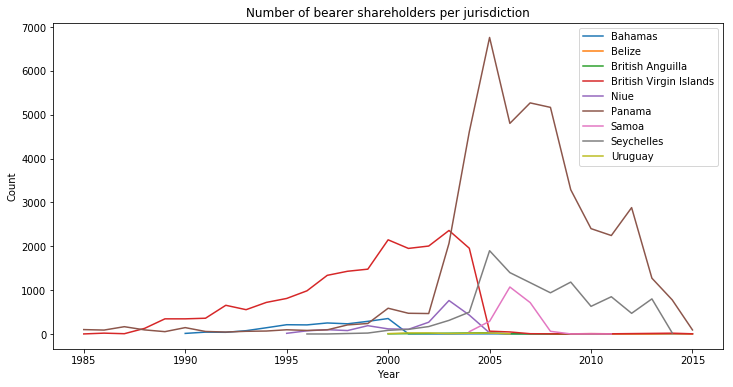

In [34]:
#Plot for each jurisdiction its number of bearer shareholders
juris_bearers = join2['jurisdiction_description'].unique()

plt.figure(figsize=(12,6))
for j in juris_bearers:
    bearer_j = join2[join2['jurisdiction_description']==j]
    plt.plot(bearer_j['incorporation_date'], bearer_j['count'])  
plt.title('Number of bearer shareholders per jurisdiction')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(juris_bearers)
plt.xticks(range(1980, 2020, 5))
plt.plot()

## Is there a link between economic and financial indicators and the involvement of a country ? That is what are the main correlates of evasion ?

## What are the insights we may extract from a social network analysis of the Panama Papers using a top down approach ? What about a specific country analysis ?

We will conduct the network analysis in two parts:
- General network analysis
- Specific country analysis

We load the dataset as a graph using the Networkx library. We then write the graph in pickle for faster loading later on.

Note that we lose roughly 20k edges link types information in the process due to multi edges between nodes. We may fix this if we intend to work on link types later on. Moreover we add a label attribute in order to display nodes labels (name/address) in Gephi.

In [61]:
'''
#Initialize directed graph from edges dataframe
G = nx.from_pandas_edgelist(edges, "START_ID", "END_ID", edge_attr='link', create_using=nx.DiGraph())

#Add nodes with node attributes from each dataframe
for i,row in entity.iterrows():
    G.add_node(row.node_id, node_type="entity", label=row.loc['name'], data=row.to_dict())

for i,row in intermediary.iterrows():
    G.add_node(row.node_id, node_type="intermediary", label=row.loc['name'], data=row.to_dict())
    
for i,row in officer.iterrows():
    G.add_node(row.node_id, node_type="officer", label=row.loc['name'], data=row.to_dict())
    
for i,row in address.iterrows():
    G.add_node(row.node_id, node_type="address", label=row.loc['address'], data=row.to_dict())
'''

Ada_ada = '''
Have you seen my beautiful baby
Have you seen my tomato baby ooo iyele
Baby softly dey cool me temper Ada
Baby na sugar sugar iyooo
Everybody dey wait
Puta kene na ogbo
Ife di m mma amaka
Better soup na money kill am o
Adanwa ngwa pekem pekem iya
Ada Ada (oyolima)
Ada Ada iyooo
Ooo'''

print(Ada_ada)


Have you seen my beautiful baby
Have you seen my tomato baby ooo iyele
Baby softly dey cool me temper Ada
Baby na sugar sugar iyooo
Everybody dey wait
Puta kene na ogbo
Ife di m mma amaka
Better soup na money kill am o
Adanwa ngwa pekem pekem iya
Ada Ada (oyolima)
Ada Ada iyooo
Ooo


Ada Ada Ooo https://www.youtube.com/watch?v=2lUFM8yTtUc

In [36]:
#nx.write_gpickle(G, "panama.gpickle")

In [37]:
G = nx.read_gpickle("panama.gpickle")

In [38]:
print('Number of edges: ', G.number_of_edges())
print('Number of nodes: ', G.number_of_nodes())

Number of edges:  657488
Number of nodes:  559600


In [39]:
#Some node data
list(G.nodes(data=True))[:2]

[(10000035,
  {'data': {'countries': 'Switzerland',
    'ibcRUC': 'R26091',
    'inactivation_date': Timestamp('2013-02-18 00:00:00'),
    'incorporation_date': Timestamp('2006-05-23 00:00:00'),
    'jurisdiction_description': 'Samoa',
    'name': 'CARPENTER NELSON & CO., LTD.',
    'node_id': 10000035,
    'status': 'Defaulted',
    'struck_off_date': Timestamp('2013-02-15 00:00:00')},
   'label': 'CARPENTER NELSON & CO., LTD.',
   'node_type': 'entity'}),
 (14095990,
  {'data': {'address': 'EUROFIN SERVICES S.A. P.O.BOX  6003 LAUSANNE 1002, VAUD SWITZERLAND',
    'countries': 'Switzerland',
    'node_id': 14095990},
   'label': 'EUROFIN SERVICES S.A. P.O.BOX  6003 LAUSANNE 1002, VAUD SWITZERLAND',
   'node_type': 'address'})]

In [40]:
#Some edge data
list(G.edges(data=True))[:2]

[(10000035, 14095990, {'link': 'registered address'}),
 (10000044, 14091035, {'link': 'registered address'})]

**Connected Components**

Let's find the connected components of this graph.  
A connected component is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the global graph.  
Note that we look at weakly connected components (that is direction is not taken into account). In our case directedness is not paramount since relations in the Panama Papers are in some way reciprocal.

In [41]:
#Get every connected component and extract giant component
components = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
giant = components[0]
giant_undir = giant.to_undirected()

In [42]:
components = sorted(components, key=lambda x: x.number_of_nodes(), reverse=True)
print("Number of connected components: {}".format(len(components)))
print("Top 10 largest connected components cardinalities: ")
print([c.number_of_nodes() for c in components[:10]])
covered = 100.0 * giant.number_of_nodes() / G.number_of_nodes()
print("The giant component covers {:.2f} % of nodes".format(covered))

Number of connected components: 11210
Top 10 largest connected components cardinalities: 
[455479, 2995, 730, 644, 597, 536, 409, 406, 380, 378]
The giant component covers 81.39 % of nodes


As one would expect when dealing with social networks we get one giant component and a multitude of "islands". This means that most of the Panama Papers graph is connected while many small groups of nodes are cut from the rest.  We will focus on the giant component.

**Clustering, Density**

Les amis de mes amis sont mes amis ? Is this network a small world [1] ? We will answer this question by computing the clustering coefficient of every node in the network.

The clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.  
The global clustering coefficient is:  
$G = \frac{\text{number of closed triplets}}{\text{number of open/closed triplets}}$  
The clustering coefficient can also be computed for each node individually.

In [43]:
#Clustering coefficient for each node
clus_coeffs = nx.clustering(giant_undir)

In [44]:
s = pd.Series(clus_coeffs)
s = s.value_counts()
print('Distribution of clustering coefficient')
s

Distribution of clustering coefficient


0.000000    455476
1.000000         1
0.002646         1
0.047619         1
dtype: int64

Well for sure the Panama Papers network is not a small world since virtually every node has a clustering coefficient of 0.

This idea of a highly dispersed network is supported by the network density measure.  
$d = \frac{2m}{n(n-1)}$ where m is the number of edges and n the number of nodes. That is the ratio of the observed sum of degrees divided by the maximum sum of degrees (complete graph).

In [45]:
#network density
print('Giant component density: ',nx.density(giant_undir))

Giant component density:  5.3792366161732275e-06


**Degree**

We will now investigate nodes degrees (number of adjacent edges for each node). As suggested in the tutorial about handling graphs we could look at in/out degrees. Here we will consider the graph as undirected.

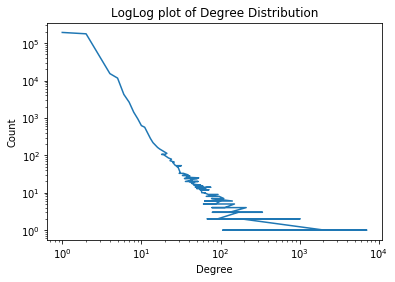

In [46]:
degs = pd.Series([d for n, d in nx.degree(giant)])
degs = degs.value_counts()
plt.loglog(degs)
plt.title("LogLog plot of Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

It looks like we are dealing with a (pseudo) power law characterized by its long tail. Indeed most of the nodes have very few neighbors whereas some of them capture most of the connections.

But what about the degree distribution per node type ?

In [47]:
#Build a dataframe of name, type, degree and country for each node
names = [giant.node[n]['label'] for n in nx.nodes(giant)]
types = [giant.node[n]['node_type'] for n in nx.nodes(giant)]
degrees = [giant.degree(n) for n in nx.nodes(giant)]
dist = pd.DataFrame(data={'name':names, 'type':types, 'degree':degrees}, index=nx.nodes(giant))

In [48]:
#Degree distribution per node type
dist.groupby('type').agg(['count', 'median', 'mean'])

degree                  
               count median       mean
type                                  
address        81937      1   1.638222
entity        169676      2   2.509129
intermediary    3096      7  54.804910
officer       200770      2   1.924262

Things get quite interesting. It looks like the heavy tail comes from intermediaries as suggested by a very small median to mean ratio. That is some intermediaries capture most of the edges present in the network.

One could argue that node degree may be a good indicator of an important node (the more people you know...), a 'key player'. Let's have a look at the top 10.

In [49]:
dist.sort_values('degree', ascending=False)[:10]

,name,type,degree
11001746,ORION HOUSE SERVICES (HK) LIMITED,intermediary,7016
11011863,MOSSACK FONSECA & CO.,intermediary,4364
11012037,PRIME CORPORATE SOLUTIONS SARL,intermediary,4117
11001708,OFFSHORE BUSINESS CONSULTANT (INT'L) LIMITED,intermediary,4094
11008027,MOSSACK FONSECA & CO. (SINGAPORE) PTE LTD.,intermediary,3888
12160432,MOSSFON SUBSCRIBERS LTD.,officer,3883
11009351,CONSULCO INTERNATIONAL LIMITED,intermediary,3168
11011539,MOSSACK FONSECA & CO. (U.K.) LIMITED,intermediary,2538
11009139,MOSSACK FONSECA & CO. (PERU) CORP.,intermediary,2055
11009218,"POWER POINT INT'L CO., LTD.",intermediary,2045


Well well well ORION HOUSE SERVICES (HK) LIMITED and MOSSACK FONSECA & CO we meet again. These two were the intermediaries that requested the most offshore companies creations.

We should not stop here. Social network analysis provides a plethora of metrics we could leverage to identify the key players. We will resort to these metrics when performing a specific country analysis.

In the meantime let's run the pagerank algorithm on the (directed) giant component [2]. Pagerank is the famous algorithm invented by Google co-founder Larry Page. Basically it performs a random walk that is made ergodic by random teleportations. The algorithm then outputs the state probability for each node. Another interesting metric (of which pagerank is a variant) would be eigenvector centrality [3].

In [50]:
pager = nx.pagerank(giant)

In [51]:
#Get pagerank for each node and add it to the dist dataframe
dist['pager'] = dist.index.map(lambda x: pager[x])

Top 10 nodes sorted per pagerank

In [52]:
dist.sort_values('pager', ascending=False)[:10]

,name,type,degree,pager
10200346,ACCELONIC LTD.,entity,1007,0.000580
14025646,AKARA BLDG.; 24 DE CASTRO STREET; WICKHAMS CAY...,address,1007,0.000538
10103570,VELA GAS INVESTMENTS LTD.,entity,493,0.000456
14026010,Akara Building; 24 de Castro Street; Wickhams ...,address,813,0.000431
14026068,Akara Building; 24 De Castro Street; Wickhams ...,address,686,0.000354
14025709,Akara Bldg.; 24 De Castro Street; Wickhams Cay...,address,667,0.000348
14001929,11 Boulevard Albert; 1er MC 98000; Monaco.,address,495,0.000286
10133161,Dale Capital Group Limited,entity,448,0.000255
14092076,"BACK IN LINE - CONSULTING, LDA RUA DE SAO BER...",address,32,0.000250
14007657,1ST FLOOR; PACIFIC BUILDING PORT VILA; VANUATU,address,438,0.000249


Read this article to learn how poor 78 year old Vernon Jenkins wound up in the Panama Papers through Accelonic Ltd. https://www.mcclatchydc.com/news/nation-world/national/article76120332.html  

In [53]:
#Saving private Jenkins
accelonic_neighbors = [giant.node[n]['label'] for n in giant_undir.neighbors(10200346)]
vernie = [v for v in accelonic_neighbors if 'VERNON' in v]
vernie

['VERNON NIEHL & CATHERINE R NIEHL JT TEN',
 'VERNON J JENKINS & LYNDA L JENKINS COMM PROP']

###  **We move on to specific country analysis**

We chose to focus on countries within the top countries with the most offshore entities while spanning a graph manageable in size.  
First we obtain their ego graphs (union of induced subgraphs of neighbors for each node located in chosen country) then we export it to Gephi for most of the analysis. Below we give an overview of the methods used.

In [54]:
#Get country or Adaland depending on node_type attribute
def get_country(node):
    if node['node_type'] == 'address':
        return 'Adaland'
    else:
        return node['data']['countries']

In [55]:
def country_ego(country, graph):
    '''Generate the graph spanned by a specific country'''
    #Get every node located in specified country
    seeds = [n for n in nx.nodes(graph) if get_country(graph.node[n]) == country]
    #Get ego graph for each node
    egos = [nx.ego_graph(graph, s) for s in seeds]
    #Compute union of ego graphs
    ego = nx.compose_all(egos)
    return ego

Example exporting Russia's ego graph to gexf format for further analysis in Gephi

In [56]:
#russia = country_ego('Russia', giant_undir)

In [57]:
#nx.write_gpickle(russia, "russia.gpickle")

In [58]:
#nx.write_gexf(russia, "russia.gexf")

In [59]:
russia = nx.read_gpickle("russia.gpickle")

**Centrality Measures**

Betweenness centrality is a measure of centrality in a network based on shortest paths.  
$bet(v)=\sum{\frac{\sigma_{st}(v)}{\sigma_{st}}}$ for every pair of nodes s, t. That is the number of shortest paths between s and t going through v divided by the number of shortest paths between s and t. The higher the betweenness, the more a node acts as a bridge between nodes [4].

Closeness centrality is a measure of centrality in a network calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. The more central a node is, the closer it is to all other nodes [4].  
$clos(x) =\frac{1}{\sum{dist(x,y)}} $

**Community Detection**

So far we've identified key players based on node importance metrics (degree, pagerank...). However we can discover deeper relationships using community detection algorithms. A community  refers to the occurrence of groups of nodes in a network that are more densely connected internally than with the rest of the network [4].

The Louvain method is a technique to extract communites. It was described in the handling graphs tutorial:  
Initially every node is considered as a community. The communities are traversed, and for each community it is tested whether by joining it to a neighboring community, we can obtain a better clustering. The metric we are trying to maximize is the modularity.  
$Q = \sum {(1-\frac{deg(i)*deg(j)}{2m})*\delta(c_i,c_j)}$ for every pair of nodes i, j. Here the delta function is 1 if i and j belong to the same community [5].

Below you will find some of the ego graphs we visualized in Gephi. Node size is a function of betweenness centrality while the color code indicates communities.

We selected the following 6 countries:
- Argentina
- Canada
- Cyprus 
- Liechtenstein
- Monaco
- Russia

Further investigations were performed using the graph query engine provided by the ICIJ (https://offshoreleaks.icij.org/).

**Argentina**

<img src="graphs/Argentina_tr.png" style="width:1000px">

Country : Argentina, Graph's modularity : 0.982

We begin with Argentina, from which we extracted 5 major entities.
<figure style="float:right;margin-left:20px;">
    <img src="proofs/proof1.png" style="width:400px">
    <figcaption> <font size = "1"> Figure 1. </font> </figcaption>
</figure>
<div style="text-align: justify">
<blockquote>The first one, <i>RIVEIRO Y ASOCIADOS</i> is the principal entity among those linked to Argentina. It is an intermediary company linked to 49 other entities that are under jursdiction of British Virgin Islands, Panama or Bahamas. Its status is still active according to the offshore leaks database.</blockquote>

<blockquote>Then we have <i>HATHERLEY LIMITED</i>, <i>Jinhua Limited</i> and <i>EDGAR ABDALA</i>. By looking at the graph, we can clearly see that these three entities seem to be connected. After investigation we found out that indeed <i>EDGAR ABDALA</i> was the intermediary of <i>Jinhua Limited</i>, which was the shareholder of <i>HATHERLEY LIMITED</i>. Hence, even though <i>HATHERLEY LIMITED</i> is linked to Seychelles and therefore not directly to Argentina, it appears on the graph. See Figure 1 for the complete connection of <i>HATHERLEY LIMITED</i>, <i>Jinhua Limited</i> and <i>EDGAR ABDALA</i>.</blockquote>

<blockquote>Finally we have <i>MARKETSITE S.A.</i> which is the intermediary of 27 entities linked to Argentina and whose status is still active, according to the offshore leaks database.</blockquote>

**Canada**

<img src="graphs/Canada_tr.png" style="width:1000px">
Country : Canada, Graph's modularity : 0.84

From Canada, we extracted 2 major entities.
<div style="text-align: justify">
<blockquote>The first one is <i>BOND & COMPANY</i>,  which is an intermediary company connected to 1166 entities. Its status is still active according to the offshore leaks database.</blockquote>


<blockquote>The second one is <i>DE GRANPRÉ CHAIT</i> and it is also an intermediary company connected to 82 entities all under British Virgin Islands jurisdiction. Its status is also still active.</blockquote>

**Cyprus**

<img src="graphs/Cyprus_tr.png" style="width:1000px">
Country : Cyprus, Graph's modularity : 0.931

We then investigated on Cyprus, from which we extracted 7 major entities.

<figure style="float:right;margin-left:20px;">
    <img src="proofs/proof2.png" style="width:500px">
    <figcaption><font size="1">Figure 1.</font></figcaption>
    <img src="proofs/proof3.png" style="width:500px">
    <figcaption> <font size="1">Figure 2.</font></figcaption>
</figure>
<div style="text-align: justify">
<blockquote>First, we have <i>Dorchester International Inc</i> and <i>CHESTERFIELD GROUP LIMITED</i> that seem to be connected to one another. <i>CHESTERFIELD GROUP LIMITED</i> is an entity registered in the Bahamas and connected to 1 entity, 5 officers and 1 intermediary. Unsuprinsingly, one of these officers is <i>Dorchester International Inc</i>. After investigation, we found out that <i>Dorchester International Inc</i> is the shareholder of many entities that are the intermediaries of <i>CHESTERFIELD GROUP LIMITED</i>, as shown on Figure 1. </blockquote>

<blockquote>
We then examined <i>ALBA CORPORATE ENTERPRISES LIMITED</i> and <i>TRADELAB LIMITED</i>, which also seem to be connected. <i>ALBA CORPORATE ENTERPRISES LIMITED</i> is an intermediary company connected to 406 entities. <i>TRADELAB LIMITED</i> is an entity registered in the Bahamas, connected to one entity, 7 officers, and 1 intermediary. Again to no one's surprise, the intermediary of <i>TRADELAB LIMITED</i> is <i>ALBA CORPORATE ENTERPRISES LIMITED</i>. See Figure 2.</blockquote>

<blockquote>
Lets look into <i>LAVECO LTD</i>. <i>LAVECO LTD</i> is actually not directly linked to Cyprus. But it is the intermediary company of 603 entities that are linked to Cyprus. This make sense since after visiting its website, we figured out that <i>LAVECO LTD.</i> offers legal solutions for offshore company formation in Cyprus, Hong-Kong, Seychelles and so on.</blockquote>

<blockquote>
Finally <i>OMNI MANAGEMENT CONSULTANCY FZE</i> and <i>FIGED</i> do not have any direct connection with the other major entities. <i>OMNI MANAGEMENT CONSULTANCY FZE</i> is an intermediary company connected to 1315 entities while <i>FIGED</i> is also an intermediary company connected to 234 entities and linked to Cyprus and Luxembourg. Both of them are still active according to the offshore leaks database.</blockquote>

</div>

**Liechtenstein**

<img src="graphs/Liechtenstein_tr.png" style="width:1000px">
Country : Liechtenstein, Graph's modularity : 0.904

From Liechtenstein we extracted 7 major entites.

<figure style="float:right;margin-left:20px;">
    <img src="proofs/proof4.png" style="width:500px">
    <figcaption> <font size="1">Figure 1.</font></figcaption>
</figure>
<div style="text-align: justify">
<blockquote> By looking at the graphe, we can see that 6 entities among the 7 major ones are connected. They are <i>Waves End Limited</i>, <i>EBENSTEIN INCORPORATED</i>, <i>Cornerways Limited</i>, <i>CLAWSON MANAGEMENT LTD</i>, <i>AUDINA TREUHAND AG</i> and <i>SEQUOIA TREUHAND TRUST REG</i>. We start by investigating on <i>Waves End Limited</i> since it has only 2 links it will be easy to find connections.<i>Waves End Limited</i> is actually not linked to Liechtenstein. But it is an officer company connected to 3 entities and one officer. We found out that 2 entities among the 3 are <i>EBENSTEIN INCORPORATED</i> and <i>CLAWSON MANAGEMENT LTD</i>. <i>EBENSTEIN INCORPORATED</i> is the intermediary of <i>SEQUOIA TREUHAND TRUST REG</i> while <i>CLAWSON MANAGEMENT LTD</i> is the intermediary of <i>AUDINA TREUHAND AG</i>. <i>Cornerways Limited</i> is the shareholder of both entities <i>EBENSTEIN INCORPORATED</i> and <i>CLAWSON MANAGEMENT LTD</i>. With the help of the offshore leaks database, the connections between these 6 entities was not hard to discover. See Figure 1 for the complete network. With connections to 583 and 222 entities respectively, <i>AUDINA TREUHAND AG</i> and <i>SEQUOIA TREUHAND TRUST REG</i> are the two main entities of Liechtenstein. This outcome supports our results presented in the graph.</blockquote>

<blockquote>
It remains <i>LOPAG TRUST REG</i>, which does not seem to be directly connected to the other 6 entities. <i>LOPAG TRUST REG</i> is an intermediary company connected to 165 entities, that are for most of them under the British Virgin Islands jurisdiction. Again, according to the offshore leaks database, <i>LOPAG TRUST REG</i> is still active.
</blockquote>

</div>

**Monaco**

<img src="graphs/Monaco_tr.png" style="width:1000px">
Country : Monaco, Graph's modularity : 0.886

From Monaco's graph we extracted 12 entities.

<figure style="float:right;margin-left:20px;">
    <img src="proofs/proof5.png" style="width:500px">
    <figcaption> <font size="1">Figure 1.</font> </figcaption>
    <img src="proofs/proof6.png" style="width:400px">
    <figcaption> <font size="1">Figure 2.</font></figcaption>
</figure>
<div style="text-align: justify">
<blockquote> While first looking at the graph we can see that there is a connection between all of the major entities but <i>AZTEC HOLDINGS LIMITED</i>. To start our investigation, we first looked for <i>Mr. Giovanni Battista BOLLORINO</i> since he has only 2 links, it will be easy to quickly find connections. We figured out that he was the shareholder of <i>LOANODUE SA</i> which was the intermediary of <i>BSI INTERNATIONAL PRIVATE BANKING S.A.M</i>. After that we saw that <i>Franco CANZI</i> was registered at the same address, <i>7 avenue Saint Roman, Monaco</i>. <i>Franco CANZI</i> is actualy the beneficary and the shareholder of <i>SPINDLER LTD</i>, which itself was the intermediary of <i>C.F.M. S.A.M</i>. Many of the shareholder of <i>SPINDLER LTD</i> were registered at the same address: <i>11 Boulevard Albert; 1er MC 98000; Monaco</i>. After few more researches on this address we found out that <i>11 Boulevard Albert; 1er MC 98000; Monaco</i> was the registration address of 495 officers. This justifies the presence of this address in our graph. See Figure 1 for a detailed network.</blockquote>

<blockquote>
To avoid digging too deep, we started back our researches from <i>BLAINE GROUP SERVICES LIMITED</i>. We figured out that <i>HSBC PRIVATE BANK (MONACO) SA</i> was its intermediary and <i>BROTHERHOOD FOUNDATION</i> one of its shareholder. See Figure 2. <i>BROTHERHOOD FOUNDATION</i> is also linked to 57 other entities and is not directly linked to Monaco but Panama, since this entity is under the Panama jurisdiction. <i>HSBC PRIVATE BANK (MONACO) SA</i> is an intermediary connected to 777 entities. Again we relied on the offshore leaks database to find out that both of them were still active.
</blockquote>

<blockquote>
We are left with <i>AZTEC HOLDINGS LIMITED</i>. We found out that it is an officer connected to 10 entities linked to Monaco. 
</blockquote>

</div>

**Russia**

<img src="graphs/Russia_tr.png" style="width:1000px">
Country : Russia, Graph's modularity : 0.923

From Russia's graph we extracted 6 major entities.

<figure style="float:right;margin-left:20px;">
    <img src="proofs/proof7.png" style="width:500px">
    <figcaption> <font size="1">Figure 1.</font></figcaption>
    <img src="proofs/proof8.png" style="width:420px">
    <figcaption> <font size="1">Figure 2.</font></figcaption>
</figure>
<div style="text-align: justify">
<blockquote> 
Since <i>LEONA GROUP LIMITED</i> and <i>FABIAN BONNELAME</i> seem to be connected we started our investigation with the latter. As shown in Figure 1, <i>FABIAN BONNELAME</i> is the shareholder and the beneficiary of <i>MOWBRAY PACIFIC LIMITED</i>, and <i>LEGAL CONSULTING SERVICES LIMITED</i> the intermediary of <i>MOWBRAY PACIFIC LIMITED</i>. We found out that <i>FABIAN BONNELAME</i> was registered at many addresses and under different names.
</blockquote>

<blockquote>
Since we did not find a connection between <i>FABIAN BONNELAME</i> and <i>LEONA GROUP LIMITED</i> yet, we investigated on <i>LEONA GROUP LIMITED</i>. Unsurprisingly, we found out that indeed <i>FABIAN BONNELAME</i> was a shareholder of <i>LEONA GROUP LIMITED</i>. We also noticed that <i>UNITRUST CORPORATE SERVICES LTD</i> was the intermediary of <i>LEONA GROUP LIMITED</i>. See Figure 2. <i>UNITRUST CORPORATE SERVICES LTD</i> is an intermediary company connected to 680 entities and linked to Russia and Canada.
</blockquote>

<blockquote>
Finally, <i>EUROGLEN S.A.</i> and <i>GLOBAL WEALTH MANAGEMENT CENTER LIMITED</i> have no direct connections. <i>EUROGLEN S.A.</i> is an intermediary company connected to 211 entities, while <i>GLOBAL WEALTH MANAGEMENT CENTER LIMITED</i> is also an intermediary company connected to 279 entities.
</blockquote>

</div>

## Models and Methods  (non exhaustive) References

[1] https://www.nature.com/articles/30918  
[2] http://ilpubs.stanford.edu:8090/422/  
[3] https://www.sciencedirect.com/science/article/pii/S0378873307000342  
[4] http://web.stanford.edu/class/cs224w/#resources  
[5] https://arxiv.org/abs/0803.0476  